# Plasma Attenuation Calculation

The radar signal will be attenuated by the plasma. This notebook calculates this attenuation in dB. Note that this calculation does not include the free space path loss term, only the attenuation due to plasma oscillation.

The formulas used for these calculations may be found in [this paper](https://fenix.tecnico.ulisboa.pt/downloadFile/281870113702780/resumo.pdf) and [this Wikipedia page](https://en.wikipedia.org/wiki/Plasma_oscillation).

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SPEED_OF_LIGHT = 3e8         # m / s
BOLTZMANNS = 1.38064852e-23  # m^2 kg s^-2 K^-1
ELECTRON_CHARGE = -1.602e-19 # A s
ELECTRON_MASS = 9.11e-31     # kg
PERMITIVITY = 8.85418782e-12 # m^-3 kg^-1 s^4 A^2

## Plasma Frequency

Plasmas can reflect or refract EM waves. All signals below a certain frequency are reflected off the plasma. Signals above this frequency penetrate the plasma but are refracted as they pass through. The frequency below which all signals are reflected is called the plasma frequency or the critical frequency.

The following formulas are from [Wikipedia](https://en.wikipedia.org/wiki/Plasma_oscillation). If the thermal motion of electrons in the plasma is ignored, then the plasma frequency

$$\omega_{\mathrm{pe}} = \sqrt{\frac{n_\mathrm{e} e^{2}}{m^*\varepsilon_0}}, \left[\mathrm{rad/s}\right]$$

where $n_\mathrm{e}$ is the number density of electrons, $e$ is the charge of an electron, $m^*$ is the (effective) mass of the electron, and $\varepsilon_0$ is the permitivity of free space.

In order to account for the thermal energy of the electrons, we add a correction term, giving us

$$\omega_p =\sqrt{\omega_{\mathrm{pe}}^2 +\frac{3k_\mathrm{B}T_{\mathrm{e}}}{m^*}k_{\mathrm{tx}}^2}$$

where $T_{\mathrm{e}}$ is the temperature, $k_B$ is Boltzmann's constant, and $k_{\mathrm{tx}}$ is the angular wavenumber of the transmitted signal.

In [2]:
def get_plasma_freq(tx_freq, density, temperature):
    cold = np.sqrt(density * ELECTRON_CHARGE ** 2 / ELECTRON_MASS / PERMITIVITY)
    wavenum = 2 * np.pi / (tx_freq / SPEED_OF_LIGHT)
    hot = np.sqrt(cold ** 2 + 3 * BOLTZMANNS * temperature / ELECTRON_MASS * wavenum ** 2)
    return hot

# Attenuation Constant

The attenuation constant is the ratio of transmitted signal power to remaining signal power per distance and it is expressed in [nepers](https://en.wikipedia.org/wiki/Neper).

The following formula is from [this paper](https://fenix.tecnico.ulisboa.pt/downloadFile/281870113702780/resumo.pdf). The attenuation constant through a given body of plasma at a certain angle of attack is

$$\alpha = \frac{\omega_p ^2 \theta}{2c(\omega_{\mathrm{tx}} + \theta)}$$

where $\theta$ is the angle of attack, $\omega_{\mathrm{tx}}$ is the frequency of the transmitted signal, and $\alpha$ is the attenuation constant in nepers.

In [3]:
def get_alpha(tx_freq, plasma_freq, angle):
    nepers = plasma_freq ** 2 * angle / 2 / SPEED_OF_LIGHT / (tx_freq ** 2 + angle ** 2)
    db = 20 * np.log10(np.e) * nepers    # convert to dB
    return db

# Non-Uniform Density Plasmas

We are interested in calculating the attenuation through the ionosphere, which does not have uniform density. We may consider a sample sounding from the [UK Solar System Data Centre Prompt Ionospheric Database](https://www.ukssdc.ac.uk/cgi-bin/digisondes/cost_database.pl) for our calculations.

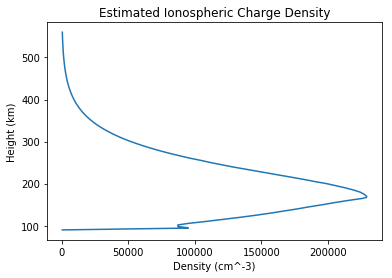

In [4]:
df = pd.read_csv('./data/clean/NHPC_Profiles-20180822115931-23558_1', delim_whitespace=True)

plt.plot(df['Density'], df['Height'])
plt.title('Estimated Ionospheric Charge Density')
plt.xlabel('Density (cm^-3)')
plt.ylabel('Height (km)')
plt.show()

We want to calculate the attenuation through the entire path from TX to RX. Thus we will add up the attenuation along our path. The attenuation constant is in $\mathrm{dB} \mathrm{m}^-1$, so we may compute the attenuation along a path $\mathcal{C}$ as

$$\int_\mathcal{C} \alpha \, ds$$

For our computation, we will consider the verticle incidence path mapped by the ionogram shown above.

In [5]:
def get_atten(tx_freq, temp, angle, df):
    heights = df['Height'] * 1000          # km to meters
    dheights = np.diff(heights)
    densities = df['Density'] / 10 ** 6    # cm^-3 to m^-3
    
    accum = 0
    for i in range(1, len(heights)):
        accum += get_alpha(tx_freq, get_plasma_freq(tx_freq, densities[i], temp), angle) * dheights[i - 1]
    
    return 2 * accum    # up and down


print(str(get_atten(4e6, 200, np.pi / 2, df)) + ' dB attenuation')   # x2 for going up and down

2.6976715582025386 dB attenuation
